<a href="https://colab.research.google.com/github/yncute/optcg_classifier/blob/main/card_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEEDS WORK:
*   implement dynamically augmented data for training and testing



##Imports

In [49]:
import json
import pickle
import pandas as pd
import cv2
import os
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance
from urllib.request import urlopen
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
import shutil
from time import localtime, strftime, time
from natsort import natsorted
from IPython.display import display

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Function definitions

(179, 128, 3)


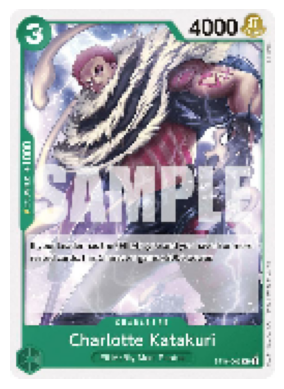

In [50]:
dataset_path = "/content/drive/MyDrive/dataset/optcg_cards"

def get_label(file_name):
  # Extract class name from filename (e.g. 'EN_ST16-003.jpg' -> 'EN_ST16-003')
  label = file_name.split('.')[0]
  return label

# Load and resize image to 313 x 224 (maintaining apsect ratio of the original 600 x 838)
def load_image(file_path, image_size=(179, 128)):
  image = tf.io.read_file(file_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, image_size)
  image = image / 255.0 # Normalize to [0,1]
  return image

# Example
image_path = dataset_path + "/EN_ST16-003.jpg"

kata = load_image(image_path)
print(kata.shape)

plt.imshow(kata)
plt.axis('off')
plt.show()

In [81]:
def get_file_paths(dataset_path, size=None):
  file_names = os.listdir(dataset_path)

  if size is None:
    file_paths = [os.path.join(dataset_path, fname) for fname in file_names]
  else:
    file_paths = [os.path.join(dataset_path, fname) for fname in file_names[:size]]
  return file_paths

def extract_labels(file_names):
  labels = [get_label(fname) for fname in file_names]
  return labels

def load_images(file_paths, image_size=(179, 128)):
  images = [load_image(fpath, image_size) for fpath in file_paths]
  return images

def convert_labels_to_int(labels):
  unique_labels = sorted(set(labels))
  label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
  int_labels = [label_to_int[label] for label in labels]
  return int_labels, unique_labels

def prepare_dataset(dataset_path, sample_size=None, image_size=(179, 128)):
  file_paths = get_file_paths(dataset_path, sample_size)

  # Extract labels from filenames
  labels = extract_labels([os.path.basename(f) for f in file_paths])

  # Load images and preprocess them
  images = load_images(file_paths, image_size)

  # Convert labels to integers
  int_labels, unique_labels = convert_labels_to_int(labels)

  return images, int_labels, unique_labels

# create tensorflow dataset, then shuffle and batch
def create_tf_dataset(images, int_labels, batch_size=32):
  dataset = tf.data.Dataset.from_tensor_slices((images, int_labels))

  dataset = dataset.shuffle(len(images)).batch(batch_size)
  return dataset


In [82]:
def augment_image(image):
    # Random horizontal flip
    if random.random() > 0.5:
        image = tf.image.flip_left_right(image)

    # Random vertical flip
    if random.random() > 0.5:
        image = tf.image.flip_up_down(image)

    # Random rotation
    angles = random.uniform(-0.2, 0.2)  # Random angle between -0.2 and 0.2 radians
    image = tf.image.rot90(image) if random.random() > 0.5 else image  # 90-degree rotation

    # Random zoom (scale)
    scale = random.uniform(0.8, 1.2)
    image = tf.image.resize(image, (int(image.shape[0] * scale), int(image.shape[1] * scale)))
    image = tf.image.resize(image, (image.shape[0], image.shape[1]))  # Resize back to original shape

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    return image

##Model Definition

In [79]:
def create_model(input_shape=(128, 179, 3), num_classes=None):
  model = models.Sequential([
      # First convolutional layer
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),

      # Second convolutional layer
      layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),

      # Third convolutional layer
      layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),

      # Flatten the output to feed into fully connected layers
      layers.Flatten(),

      # Fully connected (dense) layer
      layers.Dense(128, activation='relu'),

      # Output layer
      layers.Dense(num_classes, activation='softmax')
  ])

  return model

def compile_model(model, learning_rate=0.001):
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

# Train the model
def train_model(model, dataset, epochs=10, batch_size=32):
    model.fit(dataset, epochs=epochs, batch_size=batch_size)

##Model Training

In [75]:
dataset_path = "/content/drive/MyDrive/dataset/optcg_cards"
sample_size = 50
images, int_labels, unique_labels = prepare_dataset(dataset_path, sample_size, image_size=(179, 128))

# Print some information about the dataset
print(f"Number of images: {len(images)}")
print(f"Int labels: {int_labels}")
print(f"Unique labels: {unique_labels}")

dataset = create_tf_dataset(images, int_labels)

model = create_model(input_shape=(179,128,3), num_classes=len(unique_labels))

compile_model(model)

train_model(model, dataset, epochs=30)

Number of images: 50
Int labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Unique labels: ['EN_OP06-081', 'EN_OP06-081_p1', 'EN_OP06-082', 'EN_OP06-082_pPR', 'EN_OP06-083', 'EN_OP06-083_pPR', 'EN_OP06-084', 'EN_OP06-084_pPR', 'EN_OP06-085', 'EN_OP06-085_pPR', 'EN_OP06-086', 'EN_OP06-086_p1', 'EN_OP06-087', 'EN_OP06-087_pPR', 'EN_OP06-088', 'EN_OP06-088_pPR', 'EN_OP06-089', 'EN_OP06-089_pPR', 'EN_OP06-090', 'EN_OP06-091', 'EN_OP06-091_pPR', 'EN_OP06-092', 'EN_OP06-093', 'EN_OP06-093_p1', 'EN_OP06-093_p3', 'EN_OP06-093_p4', 'EN_OP06-094', 'EN_OP06-094_pPR', 'EN_OP06-095', 'EN_OP06-095_pPR', 'EN_OP06-096', 'EN_OP06-096_pPR', 'EN_OP06-097', 'EN_OP06-098', 'EN_OP06-098_pPR', 'EN_OP06-099', 'EN_OP06-099_pPR', 'EN_OP06-100', 'EN_OP06-100_pPR', 'EN_OP06-101', 'EN_OP06-101_p1', 'EN_OP06-101_p2', 'EN_OP06-102', 'EN_OP06-102_pPR', 'EN_OP06-103', 'EN_

##Model Evaluation and Prediction

In [76]:
loss, accuracy = model.evaluate(dataset)
print(f"Loss: {loss}, Accuracy: {accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step - accuracy: 0.8442 - loss: 0.2844
Loss: 0.2720828950405121, Accuracy: 0.8600000143051147


In [77]:
test_image = load_image("/content/drive/MyDrive/dataset/optcg_cards/EN_OP06-089_pPR.jpg")
test_image = tf.expand_dims(test_image, axis=0)  # Add batch dimension

predictions = model.predict(test_image)
predicted_class = unique_labels[tf.argmax(predictions[0]).numpy()]
print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Predicted Class: EN_OP06-089_pPR
